In [1]:
import numpy as np
from numpy import array,zeros,vstack,repeat,ones,eye,ndarray
from cvxopt import *
import pylab as pl

# What Is Privileged Information?
## Or What Makes Each Classifier Work Best?

Privileged Information is data which is only available at training time, but not available at testing time - $X$ and $X^*$. 

NOTE: $Y$ is not privileged information. $Y$ is the output from the true function $f(X)$. We are hoping to best approximate this true function.

There are 2 types of privileged data. 
1. Information about $X$. So $X^*$ just provides extra information, it isn't better information, there's just extra - think of this as more noise. $X$ has a better representation of $f(x)$ than $X^*$ does, but we want to use as much information as is available to us.
2. Information that better describes $X$. In this situation $X^*$ offers a better representation of $f(x)$ than $X$. We want to transfer this into $X$.

In both situations we only have $X^*$ at training time.

The first type of privileged information is suited to the SVM+

The second type of information is suited to the SVM$_\Delta$+.

### General Functions

In [2]:
# Generates 2D data that is largely linearly separable, but overlaps slightly
def gen_lin_separable_overlap_data(n):
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, (n//2))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, (n//2))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

# Generates 2D data that is linearly separable - no overlap
def gen_lin_separable_data(n):
    # generate training data in the 2-d case
    mean1 = np.array([0, 0])
    mean2 = np.array([4, 4])
    cov = np.array([[0.8, -0.6], [-0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, (n//2))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, (n//2))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

# Generate 2D data that can't be linearly split
def gen_non_lin_separable_data(n):
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, n//4)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, n//4)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, n//4)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, n//4)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro", label="Class +1")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo", label="Class -1")
    pl.scatter(clf.support_vectors[:,0], clf.support_vectors[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -5; a1 = f(a0, clf.w, clf.b)
    b0 = 5; b1 = f(b0, clf.w, clf.b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -5; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 5; b1 = f(b0, clf.w, clf.b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -5; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 5; b1 = f(b0, clf.w, clf.b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.xlabel('x1')
    pl.ylabel('x2')

    #pl.legend(numpoints=1)

    #pl.axis("tight")
    pl.show()
    

### Classes

In [3]:
class Linear():
    def __call__(self, a, b):
        x = np.array(a)
        y = np.array(b)
        y = np.transpose(y)
        return np.dot(x, y)

class Polynomial():
    def __call__(self, a, b, p=3):
        x = np.array(a)
        y = np.array(b)
        y = np.transpose(y)
        return (1 + np.dot(x, y)) ** p

class Gaussian():
    def __call__(self, a, b, sigma=5.0):
        x = np.array(a)
        y = np.array(b)
        y = np.transpose(y)
        return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))
    
class svm_problem():
    def __init__(self, C=1.0, gamma=1.0, delta=1.0, kernel=Linear()):
        self.C = C
        self.gamma = gamma
        self.delta = delta
        self.kernel = kernel

    def set_variables(self, X, Xstar, Y):
        if(isinstance(X, ndarray)):
            self.X = X
        else:
            self.X = array(X)
        if(isinstance(Xstar, ndarray)):
            self.Xstar = Xstar
        else:
            self.Xstar = array(Xstar)
        if(isinstance(Y, ndarray)):
            self.Y = Y
        else:
            self.Y = array(Y)
        self.num = len(self.X)
        self.dimensions = len(self.X[0])
        self.xi_xj = self.gram_matrix(self.X, self.X)
        self.xstari_xstarj = self.gram_matrix(self.Xstar, self.Xstar)
        self.xstari_xj = self.gram_matrix(self.Xstar, self.X)
        self.yi_yj = self.gram_matrix(self.Y, self.Y)

    def gram_matrix(self, X1, X2):
        K = zeros((len(X1), len(X1)))
        for i in range(len(X1)):
            for j in range(len(X1)):
                K[i,j] = self.kernel(X1[i], X2[j])
        return K
    
    def gram_matrix2(self, X1, X2):
        kernel2 = Gaussian()
        K = zeros((len(X1), len(X1)))
        for i in range(len(X1)):
            for j in range(len(X1)):
                K[i,j] = kernel2(X1[i], X2[j])
        return K
    
    
class classifier():

    def __init__(self):
        self.w = 0
        self.b = 0
        self.alphas = []
        self.support_vectors = []

    def predict(self, x):
        return np.sign(np.dot(self.w,x)+self.b)
    
    def f_star(self, x, y): # This won't make sense now, but we come back to it later
        return y*(np.dot(self.w,x)+self.b)

### Classifiers

In [4]:
class SVM():
    def train(self, x, prob : svm_problem):
        self.x = x
        self.y = prob.Y
        self.C = prob.C

        self.NUM = self.x.shape[0]

        K = self.y[:, None] * self.x # Yeah, this is a bit different so that it can work on x and x*
        K = np.dot(K, K.T)
        P = matrix(K, tc='d')
        q = matrix(-np.ones((self.NUM, 1)), tc='d')
        G1 = -np.eye(self.NUM)
        G2 = np.eye(self.NUM)
        G = np.vstack((G1, G2))
        G = matrix(G, tc='d')
        h1 = np.zeros(self.NUM).reshape(-1,1)
        h2 = np.repeat(self.C, self.NUM).reshape(-1,1)
        h = np.vstack((h1, h2))
        h = matrix(h, tc='d')
        A = matrix(self.y.reshape(1, -1), tc='d')
        b = matrix(np.zeros(1), tc='d')
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])
        w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)
        bacond1 = (self.alphas > 1e-5)
        bacond2 = (self.alphas < (self.C))
        bcond = np.array([a and b for a, b in zip(bacond1, bacond2)]).flatten()
        yS = self.y[bcond]
        xS = self.x[bcond]
        aS = self.alphas[bcond]
        sumTotal = 0
        for s in range(len(yS)):
            innerTotal = 0
            for m in range(len(yS)):
                am = aS[m]
                ym = yS[m]
                xm_xs = prob.kernel(xS[m], xS[s])
                innerTotal += am*ym*xm_xs
            sumTotal += yS[s] - innerTotal
        bias = sumTotal/len(yS)
        clf = classifier()
        clf.w = w
        clf.b = bias[0]
        clf.alphas = self.alphas
        clf.support_vectors = self.x[bacond1.flatten()]
        return clf
    
class SVMdp_simp():
    def train(self, prob : svm_problem):
        self.prob = prob
        self.x = prob.X
        self.xStar = prob.Xstar
        self.y = prob.Y
        self.C = prob.C

        self.NUM = self.x.shape[0]
        self.DIM = self.x.shape[1]
        
        self.svm = SVM()
        self.xStar_clf = self.svm.train(self.xStar, self.prob)
        
        self.xi_star_amended = np.zeros(self.NUM)
        for i in range(self.NUM):
            output = (1- self.y[i]*(np.dot(self.xStar_clf.w,self.xStar[i])+self.xStar_clf.b))
            self.xi_star_amended[i] = max(0, output)

        Ky = self.prob.yi_yj
        Kx = self.prob.xi_xj
        K = Ky*Kx
        P = matrix(K, tc='d')
        q = matrix(-np.ones((self.NUM, 1)), tc='d')
        G1 = -np.eye(self.NUM)
        G2 = np.eye(self.NUM)
        G3 = self.xi_star_amended.reshape(1,-1)
        G = np.vstack((G1, G2))
        G = np.vstack((G, G3))
        G = matrix(G, tc='d')
        h1 = np.zeros(self.NUM).reshape(-1,1)
        h2 = np.repeat(self.C, self.NUM).reshape(-1,1)
        h3 = sum(self.xi_star_amended)*self.C
        h = np.vstack((h1, h2))
        h = np.vstack((h, h3))
        h = matrix(h, tc='d')
        A = matrix(self.y.reshape(1, -1), tc='d')
        b = matrix(np.zeros(1), tc='d')
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])
        self.w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)

        bacond1 = (self.alphas > 1e-5)
        bacond2 = (self.alphas < self.C)
        bcond = np.array([a and b for a, b in zip(bacond1, bacond2)]).flatten()

        yS = self.y[bcond]
        xS = self.x[bcond]
        aS = self.alphas[bcond]

        sumTotal = 0
        for s in range(len(yS)):
            innerTotal = 0
            for m in range(len(yS)):
                am = aS[m]
                ym = yS[m]
                xm_xs = prob.kernel(xS[m], xS[s])
                innerTotal += am*ym*xm_xs
            sumTotal += yS[s] - innerTotal

        bias = sumTotal/len(yS)

        clf = classifier()
        clf.w = self.w
        clf.b = bias
        clf.alphas = self.alphas
        clf.support_vectors = self.x[bacond1.flatten()]
        return clf, self.xStar_clf
    
class SVMdp():
    def train(self, prob : svm_problem):
        self.prob = prob
        self.kernel = self.prob.kernel
        self.C = self.prob.C

        self.L = self.prob.num
        self.M = self.prob.dimensions

        self.x = self.prob.X
        self.y = self.prob.Y

        self.gamma = self.prob.gamma
        self.delta = self.prob.delta
        
        kernel = prob.kernel
        C = prob.C

        L = prob.num
        M = prob.dimensions

        x = prob.X
        y = prob.Y

        H11 = (prob.xi_xj * prob.yi_yj) + self.gamma*(prob.xstari_xstarj * prob.yi_yj)
        H12 = self.gamma*(prob.xstari_xstarj * prob.yi_yj)
        H1 = np.hstack((H11, H12))
        H2 = np.hstack((H12, H12))
        H = np.vstack((H1, H2))

        f = np.hstack((np.repeat(-1, L),np.zeros(L)))

        positiveEye = np.eye(L, dtype='d')
        negativeEye = -np.eye(L, dtype='d')
        zeros = np.zeros((L, L))
        g1 = np.hstack((zeros, negativeEye))
        g2 = np.hstack((negativeEye, zeros))
        g3 = np.hstack((positiveEye, positiveEye))

        G = np.vstack((g1,g2))
        G = np.vstack((G,g3))

        h1 = np.repeat(C, (L)).reshape(-1,1)
        h2 = np.zeros(((L),1))
        h2 = np.vstack((h1, h2))
        h3 = np.repeat((self.delta*C), L).reshape(-1,1)
        h = np.vstack((h2, h3))

        Aeq1 = np.hstack((prob.Y, np.zeros(L)))
        Aeq2 = np.hstack((prob.Y, prob.Y))
        Aeq = np.vstack((Aeq1, Aeq2))

        beq = np.zeros(2)
        beq = beq.reshape(-1,1)

        P = matrix(H, tc='d')
        q = matrix(f, tc='d')
        G = matrix(G, tc='d')
        h = matrix(h, tc='d')
        A = matrix(Aeq, tc='d')
        b = matrix(beq, tc='d')

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphasAndDeltas = np.array(sol['x'])
        self.alphas = alphasAndDeltas[:L]
        self.deltas = alphasAndDeltas[L:]
        
        self.w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)
        self.wStar = (1/self.gamma)*np.sum((self.alphas + self.deltas) * self.y[:, None] * self.prob.Xstar, axis = 0)
        
        bacond = (self.alphas > 1e-5)
        bdcond = (self.deltas + self.C > 1e-5)

        bcond = np.array([a and b for a, b in zip(bacond, bdcond)]).flatten()
        
        clf = classifier()
        clf.w = self.w
        self.b = self.getB()
        clf.b = self.b
        clf.alphas = self.alphas
        clf.support_vectors = self.x[bacond.flatten()]
        
        priv_clf = classifier()
        priv_clf.w = self.wStar
        priv_clf.b = self.getBstar()
        priv_clf.support_vectors = self.prob.Xstar[np.array(bacond).flatten()]
        return clf, priv_clf
    
    def F(self, i):
        runningTotal = 0
        for j in range(self.L):
            runningTotal += self.alphas[j] * self.y[j] * self.prob.kernel(self.x[i], self.x[j])
        return runningTotal[0]
    
    def f(self, i):
        runningTotal = 0
        for j in range(self.L):
            runningTotal += (self.alphas[j] + self.deltas[j]) * self.prob.kernel(self.xStar[i], self.xStar[j])
            if (self.alphas[j] + self.deltas[j] > -1e-5) and (self.alphas[j] + self.deltas[j] < 1e-5):
                print("This makes a < C ",j)
        return runningTotal[0]
    
    def sPos(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.deltas[i] -self.C < 1e-5 and self.y[i] == 1:
                runningTotal += 1-np.dot(self.w, self.prob.X[i])
        return runningTotal
    
    def sNeg(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.deltas[i] -self.C < 1e-5 and self.y[i] == -1:
                runningTotal += -1 - np.dot(self.w, self.prob.X[i])
        return runningTotal
    
    def nPos(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.deltas[i] -self.C < 1e-5 and self.y[i] == 1:
                runningTotal += 1
        return runningTotal
    
    def nNeg(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.deltas[i] -self.C < 1e-5 and self.y[i] == -1:
                runningTotal += 1
        return runningTotal
    
    def getB(self):
        return ((self.sPos()/self.nPos())+(self.sNeg()/self.nNeg()))/2
    
    def q(self):
        runningTotal = 0
        for i in range(self.L):
            if self.deltas[i] + self.C > 1e-5:
                runningTotal += np.dot(self.w, self.prob.X[i])/2 - np.dot(self.wStar, self.prob.Xstar[i])
        return runningTotal
    
    def getBstar(self):
        return self.q() / self.L
    
    
class SVMp():
    def train(self, prob : svm_problem):
        self.prob = prob
        self.C = self.prob.C

        self.L = self.prob.num

        self.x = self.prob.X
        self.xStar = self.prob.Xstar
        self.y = self.prob.Y

        self.gamma = self.prob.gamma

        P1 = (self.prob.xi_xj * self.prob.yi_yj) + self.gamma*(self.prob.xstari_xstarj)
        P2 = self.gamma*(self.prob.xstari_xstarj)
        P11 = np.hstack((P1, P2))
        P22 = np.hstack((P2, P2))
        P = np.vstack((P11, P22))

        q = np.hstack((np.repeat(-1, self.L),np.zeros(self.L)))

        positiveEye = np.eye(self.L, dtype='d')
        negativeEye = -np.eye(self.L, dtype='d')
        zeros = np.zeros((self.L, self.L))
        g1 = np.hstack((negativeEye, zeros))
        g2 = np.hstack((zeros, negativeEye))

        G = np.vstack((g1,g2))

        h1 = np.zeros(((self.L),1))
        h2 = np.repeat(self.C, (self.L)).reshape(-1,1)
        h = np.vstack((h1, h2))

        A1 = np.repeat(1, 2*self.L)
        A2 = np.hstack((self.y, np.zeros(self.L)))
        A = np.vstack((A1, A2))

        b = np.zeros(2)
        b = b.reshape(-1,1)

        P = matrix(P, tc='d')
        q = matrix(q, tc='d')
        G = matrix(G, tc='d')
        h = matrix(h, tc='d')
        A = matrix(A, tc='d')
        b = matrix(b, tc='d')

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphasAndDeltas = np.array(sol['x'])
        self.alphas = alphasAndDeltas[:self.L]
        self.deltas = alphasAndDeltas[self.L:]

        # Not really writing about it, w as before        
        self.w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)
        self.wStar = (1/self.gamma)*np.sum((self.alphas + self.deltas) * self.prob.Xstar, axis = 0)
        #bias = self.getB()
        
        bacond = (self.alphas > 1e-5)
        bdcond = (self.deltas + self.C > 1e-5)

        bcond = np.array([a and b for a, b in zip(bacond, bdcond)]).flatten()
        ####
        
        clf = classifier()
        clf.w = self.w
        clf.b = self.getB()
        clf.alphas = self.alphas
        clf.support_vectors = self.x[(self.alphas > 1e-5).flatten()]
        clf1 = classifier()
        clf1.w = self.wStar
        clf1.b = self.getBstar()
        clf1.alphas = self.alphas
        clf1.support_vectors = self.prob.Xstar[bcond]
        return clf, clf1
    
    def F(self, i):
        runningTotal = 0
        for j in range(self.L):
            runningTotal += self.alphas[j] * self.y[j] * self.prob.kernel(self.x[i], self.x[j])
        return runningTotal[0]
    
    def f(self, i):
        runningTotal = 0
        for j in range(self.L):
            runningTotal += (self.alphas[j] + self.deltas[j]) * self.prob.kernel(self.xStar[i], self.xStar[j])
            if (self.alphas[j] + self.deltas[j] > -1e-5) and (self.alphas[j] + self.deltas[j] < 1e-5):
                print("This makes a < C ",j)
        return runningTotal[0]
    
    def sPos(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == 1:
                runningTotal += 1-(self.f(i)/self.gamma)-self.F(i)
        return runningTotal
    
    def sNeg(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == -1:
                runningTotal += 1-(self.f(i)/self.gamma)-self.F(i)
        return runningTotal
    
    def nPos(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == 1:
                runningTotal += 1
        return runningTotal
    
    def nNeg(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == -1:
                runningTotal += 1
        return runningTotal
    
    def getB(self):
        return ((self.bPlusbStar()/self.nPos())+(self.bMinusbStar()/self.nNeg()))/2
    
    def getBstar(self):
        return ((self.bPlusbStar()/self.nPos())-(self.bMinusbStar()/self.nNeg()))/2
    
    def bPlusbStar(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == 1:
                runningTotal += 1 - np.dot(self.wStar, self.xStar[i]) - np.dot(self.w, self.x[i])
        return runningTotal
    
    
    def bMinusbStar(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == -1:
                runningTotal += -1 + np.dot(self.wStar, self.xStar[i]) - np.dot(self.w, self.x[i])
        return runningTotal

## Let's generate some training triplets

There are possible 9 combinations

| Problem Number |         $X$        |        $X^*$       | Predicted Best Classifier |
|:--------------:|:------------------:|:------------------:|:-------------------------:|
|        1       | Linearly Separable | Linearly Separable |            SVM            |
|        2       | Linearly Separable |   Linear Overlap   |            SVM            |
|        3       | Linearly Separable |    Non Separable   |            SVM            |
|        4       |   Linear Overlap   | Linearly Separable |       SVM Delta Plus      |
|        5       |   Linear Overlap   |   Linear Overlap   |            SVM+           |
|        6       |   Linear Overlap   |    Non Separable   |            SVM+           |
|        7       |    Non Separable   | Linearly Separable |       SVM Delta Plus      |
|        8       |    Non Separable   |   Linear Overlap   |       SVM Delta Plus      |
|        9       |    Non Separable   |    Non Separable   |            ???            |

In [5]:
x1, y1, x2, y2 = gen_lin_separable_data(100)
lin_sep = np.vstack((x1,x2))
Y = np.hstack((y1,y2))
x3,y1,x4,y2 = gen_lin_separable_overlap_data(100)
lin_over = np.vstack((x3,x4))
x5,y1,x6,y2 = gen_non_lin_separable_data(100)
non_lin = np.vstack((x5,x6))

prob1 = svm_problem()
prob1.set_variables(lin_sep, lin_sep, Y)

prob2 = svm_problem()
prob2.set_variables(lin_sep, lin_over, Y)

prob3 = svm_problem()
prob3.set_variables(lin_sep, non_lin, Y)

prob4 = svm_problem()
prob4.set_variables(lin_over, lin_sep, Y)

prob5 = svm_problem()
prob5.set_variables(lin_over, lin_over, Y)

prob6 = svm_problem()
prob6.set_variables(lin_over, non_lin, Y)

prob7 = svm_problem()
prob7.set_variables(non_lin, lin_sep, Y)

prob8 = svm_problem()
prob8.set_variables(non_lin, lin_over, Y)

prob9 = svm_problem()
prob9.set_variables(non_lin, non_lin, Y)

## Classifiers on Problem 1

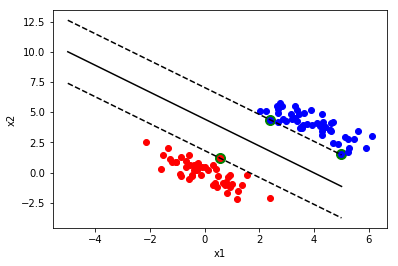

In [6]:
svm_prob1 = SVM()
svm_prob1_clf = svm_prob1.train(prob1.X, prob1)
plot_margin(prob1.X[prob1.Y==1], prob1.X[prob1.Y==-1], svm_prob1_clf)

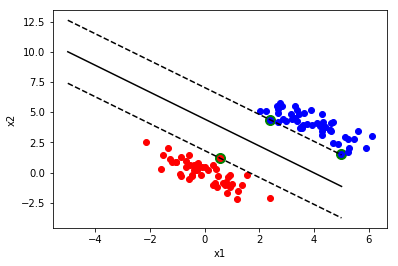

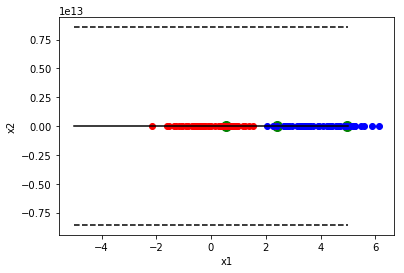

In [7]:
svmp_prob1 = SVMp()
svmp_prob1_clf_x, svmp_prob1_clf_xStar = svmp_prob1.train(prob1)
plot_margin(prob1.X[prob1.Y==1], prob1.X[prob1.Y==-1], svmp_prob1_clf_x)
plot_margin(prob1.Xstar[prob1.Y==1], prob1.Xstar[prob1.Y==-1], svmp_prob1_clf_xStar)

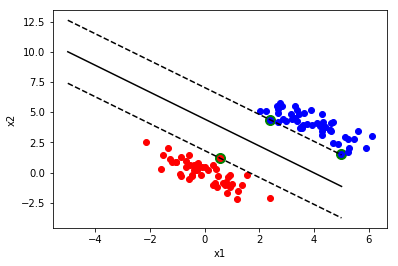

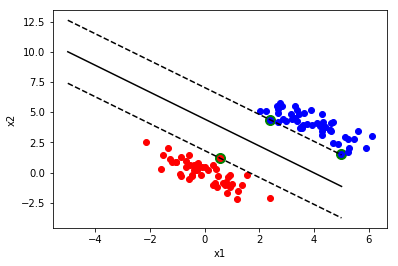

In [8]:
svmdps_prob1 = SVMdp_simp()
svmdps_prob1_clf_x, svmdps_prob1_clf_xStar = svmdps_prob1.train(prob1)
plot_margin(prob1.X[prob1.Y==1], prob1.X[prob1.Y==-1], svmdps_prob1_clf_x)
plot_margin(prob1.Xstar[prob1.Y==1], prob1.Xstar[prob1.Y==-1], svmdps_prob1_clf_xStar)

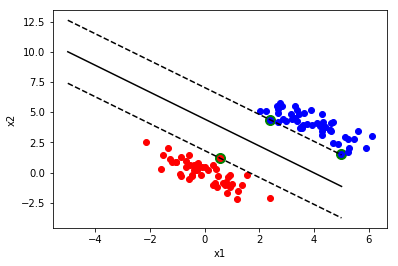

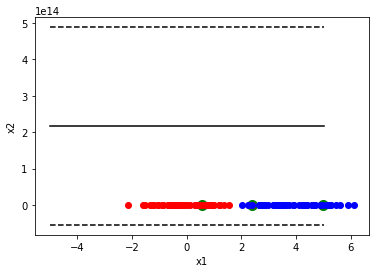

In [9]:
svmdp_prob1 = SVMdp()
svmdp_prob1_clf_x, svmdp_prob1_clf_xStar = svmdp_prob1.train(prob1)
plot_margin(prob1.X[prob1.Y==1], prob1.X[prob1.Y==-1], svmdp_prob1_clf_x)
plot_margin(prob1.Xstar[prob1.Y==1], prob1.Xstar[prob1.Y==-1], svmdp_prob1_clf_xStar)

## Classifiers on Problem 2

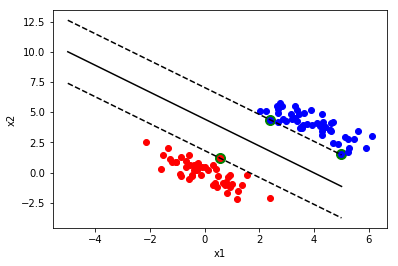

In [10]:
svm_prob2 = SVM()
svm_prob2_clf = svm_prob2.train(prob2.X, prob2)
plot_margin(prob2.X[prob2.Y==1], prob2.X[prob1.Y==-1], svm_prob2_clf)

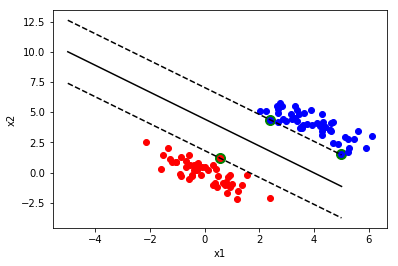

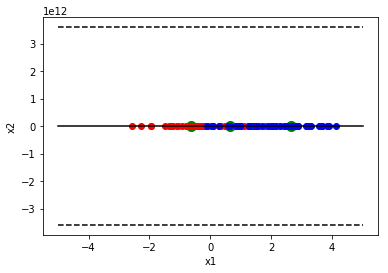

In [11]:
svmp_prob2 = SVMp()
svmp_prob2_clf_x, svmp_prob2_clf_xStar = svmp_prob2.train(prob2)
plot_margin(prob1.X[prob2.Y==1], prob2.X[prob2.Y==-1], svmp_prob2_clf_x)
plot_margin(prob2.Xstar[prob2.Y==1], prob2.Xstar[prob2.Y==-1], svmp_prob2_clf_xStar)

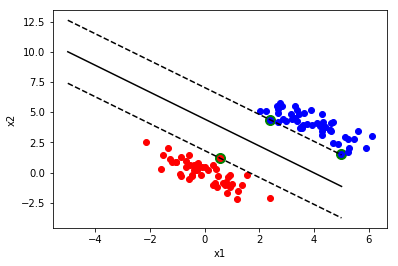

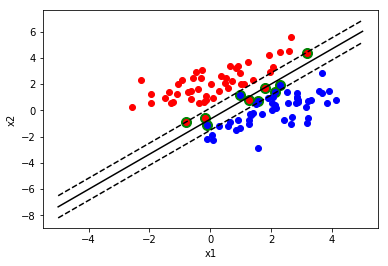

In [12]:
svmdps_prob2 = SVMdp_simp()
svmdps_prob2_clf_x, svmdps_prob2_clf_xStar = svmdps_prob2.train(prob2)
plot_margin(prob2.X[prob2.Y==1], prob2.X[prob2.Y==-1], svmdps_prob2_clf_x)
plot_margin(prob2.Xstar[prob2.Y==1], prob2.Xstar[prob2.Y==-1], svmdps_prob2_clf_xStar)

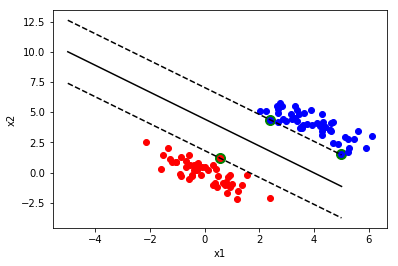

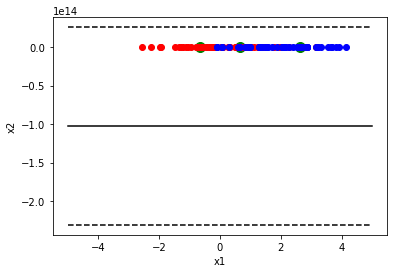

In [13]:
svmdp_prob2 = SVMdp()
svmdp_prob2_clf_x, svmdp_prob2_clf_xStar = svmdp_prob2.train(prob2)
plot_margin(prob2.X[prob2.Y==1], prob2.X[prob2.Y==-1], svmdp_prob2_clf_x)
plot_margin(prob2.Xstar[prob2.Y==1], prob2.Xstar[prob2.Y==-1], svmdp_prob2_clf_xStar)

## Classifiers on Problem 3

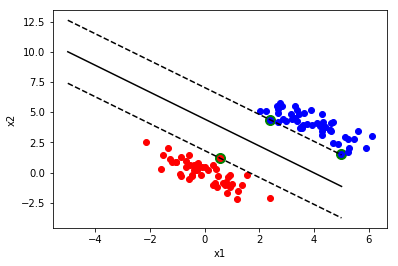

In [14]:
svm_prob3 = SVM()
svm_prob3_clf = svm_prob3.train(prob3.X, prob3)
plot_margin(prob3.X[prob3.Y==1], prob3.X[prob3.Y==-1], svm_prob3_clf)

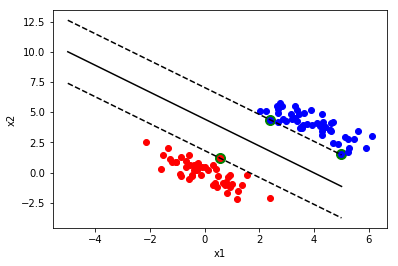

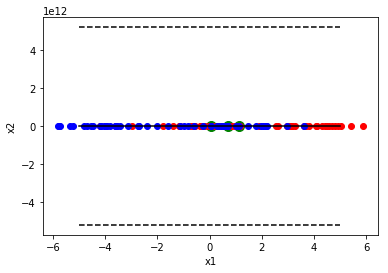

In [15]:
svmp_prob3 = SVMp()
svmp_prob3_clf_x, svmp_prob3_clf_xStar = svmp_prob3.train(prob3)
plot_margin(prob3.X[prob3.Y==1], prob3.X[prob3.Y==-1], svmp_prob3_clf_x)
plot_margin(prob3.Xstar[prob3.Y==1], prob3.Xstar[prob3.Y==-1], svmp_prob3_clf_xStar)

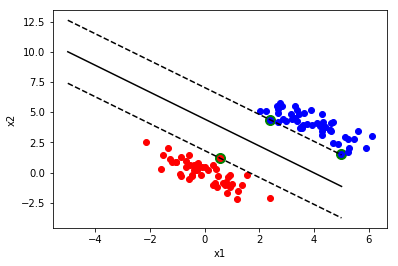

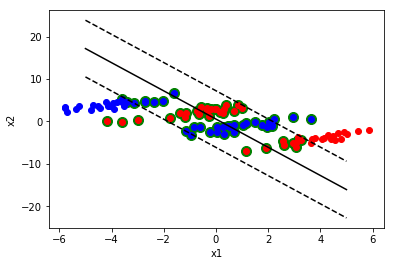

In [16]:
svmdps_prob3 = SVMdp_simp()
svmdps_prob3_clf_x, svmdps_prob3_clf_xStar = svmdps_prob3.train(prob3)
plot_margin(prob3.X[prob3.Y==1], prob3.X[prob3.Y==-1], svmdps_prob3_clf_x)
plot_margin(prob3.Xstar[prob3.Y==1], prob3.Xstar[prob3.Y==-1], svmdps_prob3_clf_xStar)

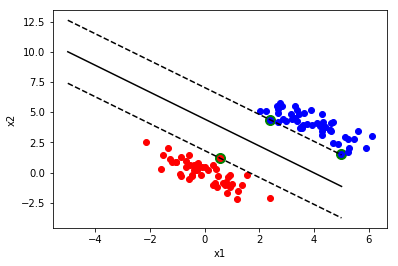

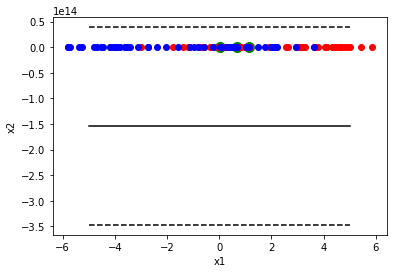

In [17]:
svmdp_prob3 = SVMdp()
svmdp_prob3_clf_x, svmdp_prob3_clf_xStar = svmdp_prob3.train(prob3)
plot_margin(prob3.X[prob3.Y==1], prob3.X[prob3.Y==-1], svmdp_prob3_clf_x)
plot_margin(prob3.Xstar[prob3.Y==1], prob3.Xstar[prob3.Y==-1], svmdp_prob3_clf_xStar)

## Classifiers on Problem 4

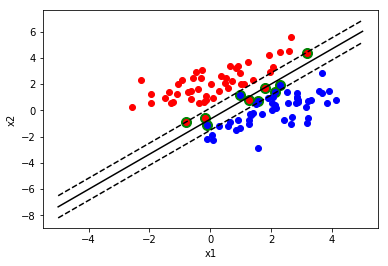

In [18]:
svm_prob4 = SVM()
svm_prob4_clf = svm_prob4.train(prob4.X, prob4)
plot_margin(prob4.X[prob4.Y==1], prob4.X[prob4.Y==-1], svm_prob4_clf)

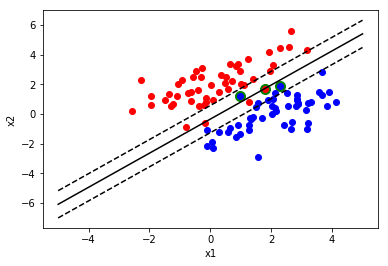

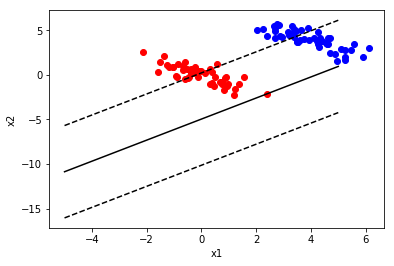

In [19]:
svmp_prob4 = SVMp()
svmp_prob4_clf_x, svmp_prob4_clf_xStar = svmp_prob4.train(prob4)
plot_margin(prob4.X[prob4.Y==1], prob4.X[prob4.Y==-1], svmp_prob4_clf_x)
plot_margin(prob4.Xstar[prob4.Y==1], prob4.Xstar[prob4.Y==-1], svmp_prob4_clf_xStar)

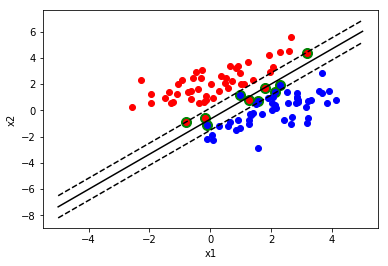

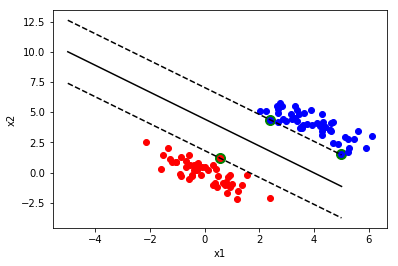

In [20]:
svmdps_prob4 = SVMdp_simp()
svmdps_prob4_clf_x, svmdps_prob4_clf_xStar = svmdps_prob4.train(prob4)
plot_margin(prob4.X[prob4.Y==1], prob4.X[prob4.Y==-1], svmdps_prob4_clf_x)
plot_margin(prob4.Xstar[prob4.Y==1], prob4.Xstar[prob4.Y==-1], svmdps_prob4_clf_xStar)

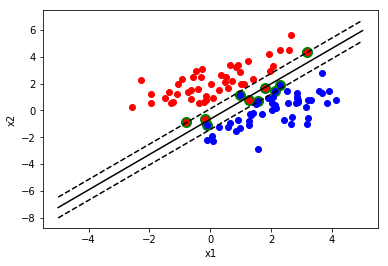

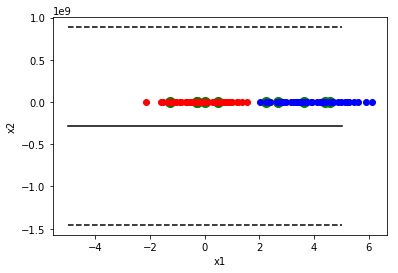

In [21]:
svmdp_prob4 = SVMdp()
svmdp_prob4_clf_x, svmdp_prob4_clf_xStar = svmdp_prob4.train(prob4)
plot_margin(prob4.X[prob4.Y==1], prob4.X[prob4.Y==-1], svmdp_prob4_clf_x)
plot_margin(prob4.Xstar[prob4.Y==1], prob4.Xstar[prob4.Y==-1], svmdp_prob4_clf_xStar)

## Classifiers on Problem 5

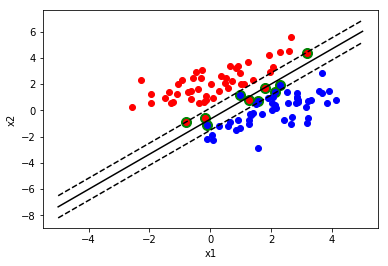

In [22]:
svm_prob5 = SVM()
svm_prob5_clf = svm_prob5.train(prob5.X, prob5)
plot_margin(prob5.X[prob5.Y==1], prob5.X[prob5.Y==-1], svm_prob5_clf)

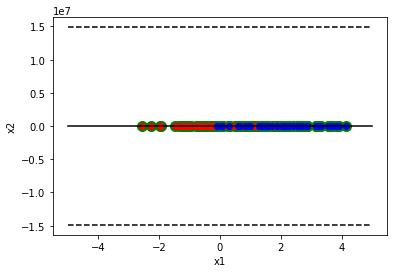

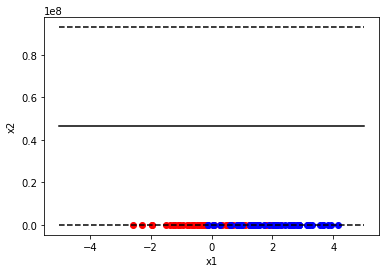

In [23]:
svmp_prob5 = SVMp()
svmp_prob5_clf_x, svmp_prob5_clf_xStar = svmp_prob5.train(prob5)
plot_margin(prob5.X[prob5.Y==1], prob5.X[prob5.Y==-1], svmp_prob5_clf_x)
plot_margin(prob5.Xstar[prob5.Y==1], prob5.Xstar[prob5.Y==-1], svmp_prob5_clf_xStar)

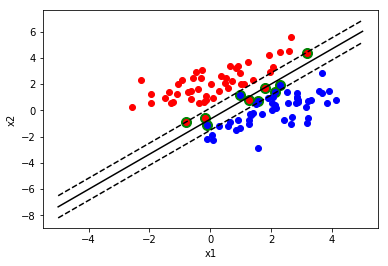

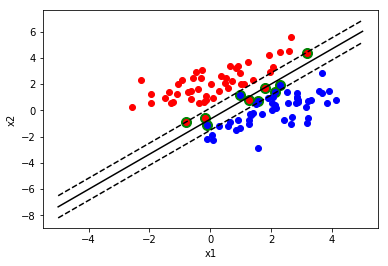

In [24]:
svmdps_prob5 = SVMdp_simp()
svmdps_prob5_clf_x, svmdps_prob5_clf_xStar = svmdps_prob5.train(prob5)
plot_margin(prob5.X[prob5.Y==1], prob5.X[prob5.Y==-1], svmdps_prob5_clf_x)
plot_margin(prob5.Xstar[prob5.Y==1], prob5.Xstar[prob5.Y==-1], svmdps_prob5_clf_xStar)

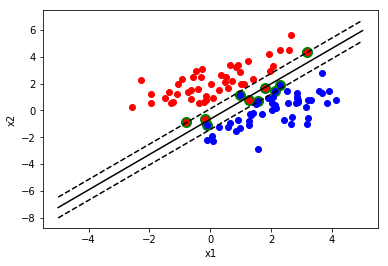

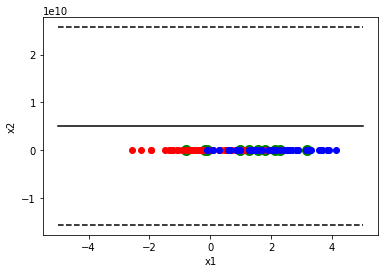

In [25]:
svmdp_prob5 = SVMdp()
svmdp_prob5_clf_x, svmdp_prob5_clf_xStar = svmdp_prob5.train(prob5)
plot_margin(prob5.X[prob5.Y==1], prob5.X[prob5.Y==-1], svmdp_prob5_clf_x)
plot_margin(prob5.Xstar[prob5.Y==1], prob5.Xstar[prob5.Y==-1], svmdp_prob5_clf_xStar)

## Classifiers on Problem 6

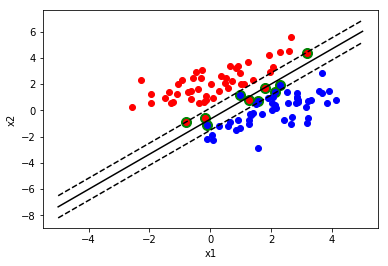

In [26]:
svm_prob6 = SVM()
svm_prob6_clf = svm_prob6.train(prob6.X, prob6)
plot_margin(prob6.X[prob6.Y==1], prob6.X[prob6.Y==-1], svm_prob6_clf)

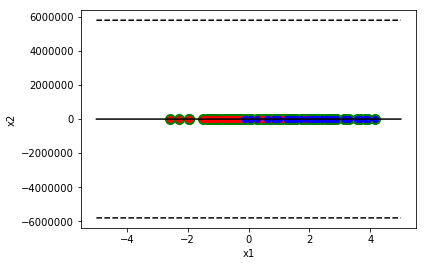

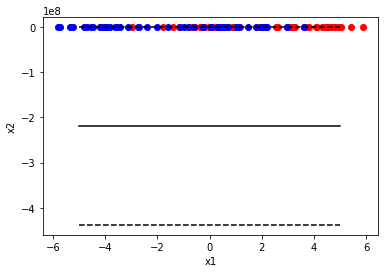

In [27]:
svmp_prob6 = SVMp()
svmp_prob6_clf_x, svmp_prob6_clf_xStar = svmp_prob6.train(prob6)
plot_margin(prob6.X[prob6.Y==1], prob6.X[prob6.Y==-1], svmp_prob6_clf_x)
plot_margin(prob6.Xstar[prob6.Y==1], prob6.Xstar[prob6.Y==-1], svmp_prob6_clf_xStar)

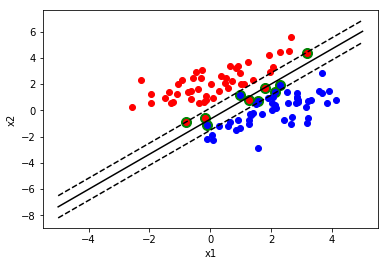

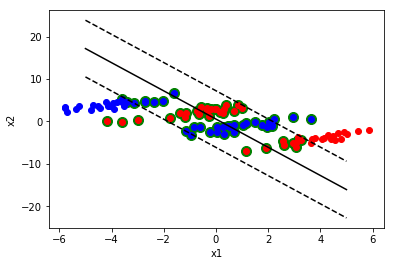

In [28]:
svmdps_prob6 = SVMdp_simp()
svmdps_prob6_clf_x, svmdps_prob6_clf_xStar = svmdps_prob6.train(prob6)
plot_margin(prob6.X[prob6.Y==1], prob6.X[prob6.Y==-1], svmdps_prob6_clf_x)
plot_margin(prob6.Xstar[prob6.Y==1], prob6.Xstar[prob6.Y==-1], svmdps_prob6_clf_xStar)

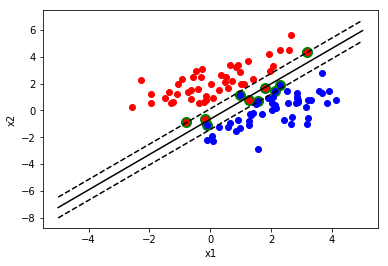

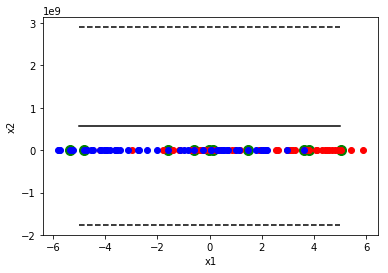

In [29]:
svmdp_prob6 = SVMdp()
svmdp_prob6_clf_x, svmdp_prob6_clf_xStar = svmdp_prob6.train(prob6)
plot_margin(prob6.X[prob6.Y==1], prob6.X[prob6.Y==-1], svmdp_prob6_clf_x)
plot_margin(prob6.Xstar[prob6.Y==1], prob6.Xstar[prob6.Y==-1], svmdp_prob6_clf_xStar)

## Classifiers on Problem 7

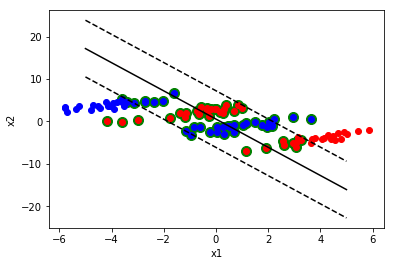

In [30]:
svm_prob7 = SVM()
svm_prob7_clf = svm_prob7.train(prob7.X, prob7)
plot_margin(prob7.X[prob7.Y==1], prob7.X[prob7.Y==-1], svm_prob7_clf)

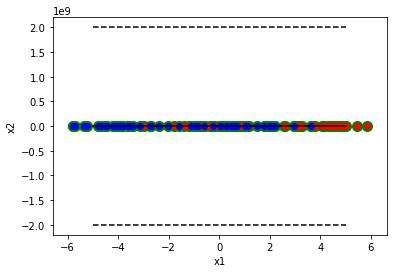

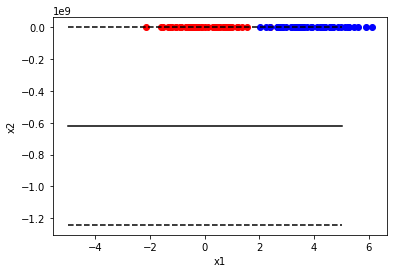

In [31]:
svmp_prob7 = SVMp()
svmp_prob7_clf_x, svmp_prob7_clf_xStar = svmp_prob7.train(prob7)
plot_margin(prob7.X[prob7.Y==1], prob7.X[prob7.Y==-1], svmp_prob7_clf_x)
plot_margin(prob7.Xstar[prob7.Y==1], prob7.Xstar[prob7.Y==-1], svmp_prob7_clf_xStar)

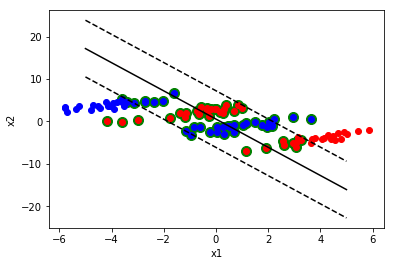

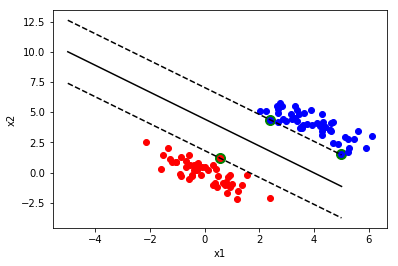

In [32]:
svmdps_prob7 = SVMdp_simp()
svmdps_prob7_clf_x, svmdps_prob7_clf_xStar = svmdps_prob7.train(prob7)
plot_margin(prob7.X[prob7.Y==1], prob7.X[prob7.Y==-1], svmdps_prob7_clf_x)
plot_margin(prob7.Xstar[prob7.Y==1], prob7.Xstar[prob7.Y==-1], svmdps_prob7_clf_xStar)

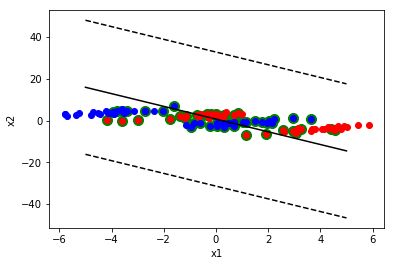

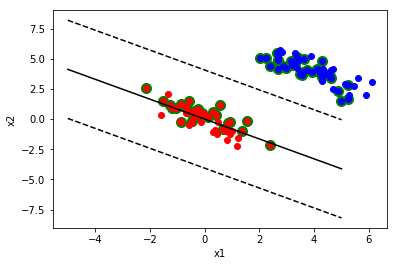

In [33]:
svmdp_prob7 = SVMdp()
svmdp_prob7_clf_x, svmdp_prob7_clf_xStar = svmdp_prob7.train(prob7)
plot_margin(prob7.X[prob7.Y==1], prob7.X[prob7.Y==-1], svmdp_prob7_clf_x)
plot_margin(prob7.Xstar[prob7.Y==1], prob7.Xstar[prob7.Y==-1], svmdp_prob7_clf_xStar)

## Classifiers on Problem 8

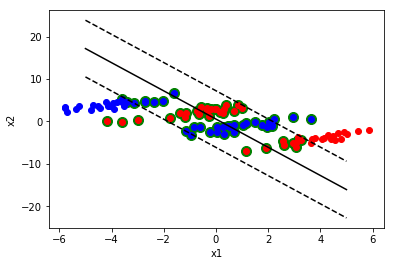

In [34]:
svm_prob8 = SVM()
svm_prob8_clf = svm_prob8.train(prob8.X, prob8)
plot_margin(prob8.X[prob8.Y==1], prob8.X[prob8.Y==-1], svm_prob8_clf)

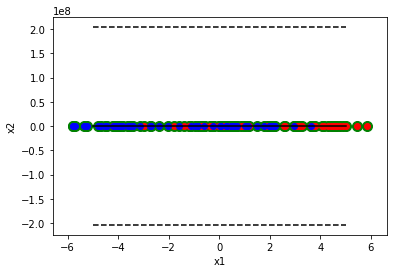

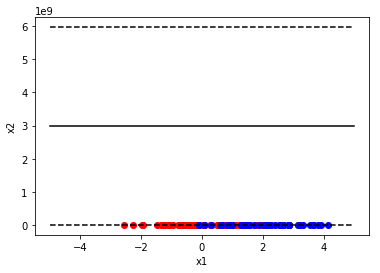

In [35]:
svmp_prob8 = SVMp()
svmp_prob8_clf_x, svmp_prob8_clf_xStar = svmp_prob8.train(prob8)
plot_margin(prob8.X[prob8.Y==1], prob8.X[prob8.Y==-1], svmp_prob8_clf_x)
plot_margin(prob8.Xstar[prob8.Y==1], prob8.Xstar[prob8.Y==-1], svmp_prob8_clf_xStar)

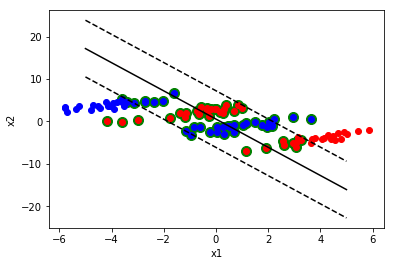

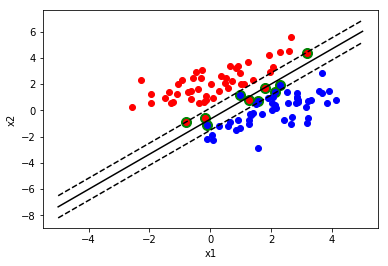

In [36]:
svmdps_prob8 = SVMdp_simp()
svmdps_prob8_clf_x, svmdps_prob8_clf_xStar = svmdps_prob8.train(prob8)
plot_margin(prob8.X[prob8.Y==1], prob8.X[prob8.Y==-1], svmdps_prob8_clf_x)
plot_margin(prob8.Xstar[prob8.Y==1], prob8.Xstar[prob8.Y==-1], svmdps_prob8_clf_xStar)

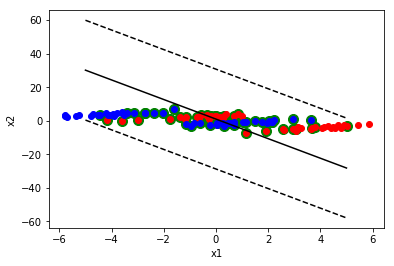

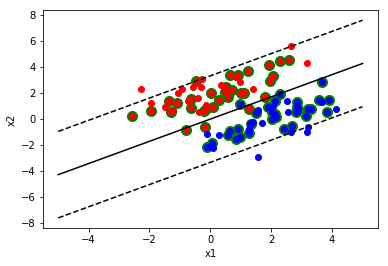

In [37]:
svmdp_prob8 = SVMdp()
svmdp_prob8_clf_x, svmdp_prob8_clf_xStar = svmdp_prob8.train(prob8)
plot_margin(prob8.X[prob8.Y==1], prob8.X[prob8.Y==-1], svmdp_prob8_clf_x)
plot_margin(prob8.Xstar[prob8.Y==1], prob8.Xstar[prob8.Y==-1], svmdp_prob8_clf_xStar)

## Classifiers on Problem 9

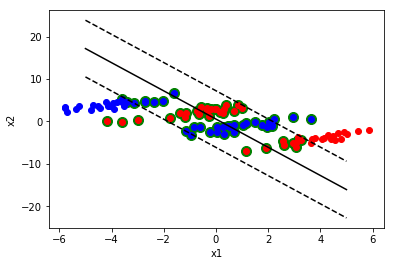

In [38]:
svm_prob9 = SVM()
svm_prob9_clf = svm_prob9.train(prob9.X, prob9)
plot_margin(prob9.X[prob9.Y==1], prob9.X[prob9.Y==-1], svm_prob9_clf)

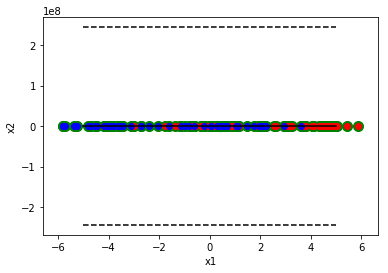

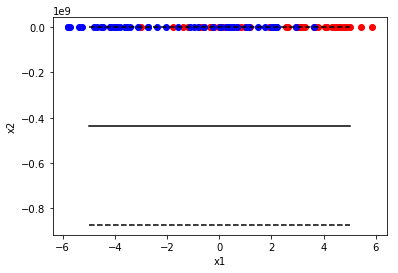

In [39]:
svmp_prob9 = SVMp()
svmp_prob9_clf_x, svmp_prob9_clf_xStar = svmp_prob9.train(prob9)
plot_margin(prob9.X[prob9.Y==1], prob9.X[prob9.Y==-1], svmp_prob9_clf_x)
plot_margin(prob9.Xstar[prob9.Y==1], prob9.Xstar[prob9.Y==-1], svmp_prob9_clf_xStar)

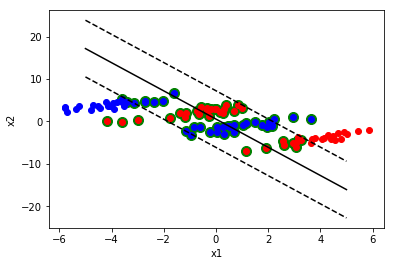

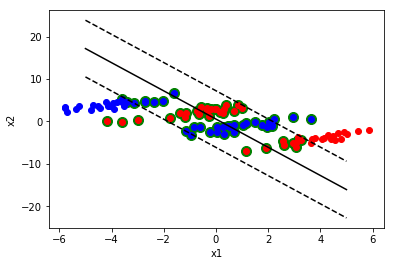

In [40]:
svmdps_prob9 = SVMdp_simp()
svmdps_prob9_clf_x, svmdps_prob9_clf_xStar = svmdps_prob9.train(prob9)
plot_margin(prob9.X[prob9.Y==1], prob9.X[prob9.Y==-1], svmdps_prob9_clf_x)
plot_margin(prob9.Xstar[prob9.Y==1], prob9.Xstar[prob9.Y==-1], svmdps_prob9_clf_xStar)

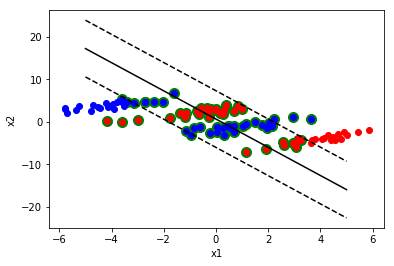

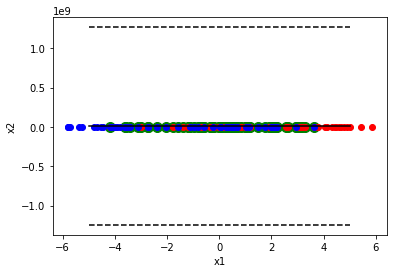

In [41]:
svmdp_prob9 = SVMdp()
svmdp_prob9_clf_x, svmdp_prob9_clf_xStar = svmdp_prob9.train(prob9)
plot_margin(prob9.X[prob9.Y==1], prob9.X[prob9.Y==-1], svmdp_prob9_clf_x)
plot_margin(prob9.Xstar[prob9.Y==1], prob9.Xstar[prob9.Y==-1], svmdp_prob9_clf_xStar)